<a href="https://colab.research.google.com/github/BaiganKing/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

drinks = ['coke', 'sprite', 'juice', 'water']

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.discrete.discrete_model as smdis
import statsmodels.stats.outliers_influence as outliers
from google.colab import files

In [6]:
uploaded = files.upload() 
#csv used - https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/P12-Churn-Modelling-Test-Data.csv

Saving P12-Churn-Modelling-Test-Data.csv to P12-Churn-Modelling-Test-Data.csv


In [7]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "P12-Churn-Modelling-Test-Data.csv" with length 69498 bytes


In [0]:
df = pd.read_csv("P12-Churn-Modelling-Test-Data.csv", index_col=None)

In [9]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,10001,15798485,Copley,565,France,Male,31,1,0.00,1,0,1,20443.08,0
1,10002,15588959,T'ang,569,France,Male,34,4,0.00,1,0,1,4045.90,0
2,10003,15624896,Ku,669,France,Female,20,7,0.00,2,1,0,128838.67,0
3,10004,15639629,McConnan,694,France,Male,39,4,173255.48,1,1,1,81293.10,0
4,10005,15638852,Ts'ui,504,Spain,Male,28,10,109291.36,1,1,1,187593.15,0


In [0]:
df_y = df['Exited']
df_x = df.drop(['Exited'], axis = 1)

In [0]:
dummy = pd.get_dummies(df_x['Gender'])
df_x = dummy.join(df_x)
dummy = pd.get_dummies(df_x['Geography'])
df_x = dummy.join(df_x)

In [12]:
df_x.head()

,France,Germany,Spain,Female,Male,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1,0,0,0,1,10001,15798485,Copley,565,France,Male,31,1,0.00,1,0,1,20443.08
1,1,0,0,0,1,10002,15588959,T'ang,569,France,Male,34,4,0.00,1,0,1,4045.90
2,1,0,0,1,0,10003,15624896,Ku,669,France,Female,20,7,0.00,2,1,0,128838.67
3,1,0,0,0,1,10004,15639629,McConnan,694,France,Male,39,4,173255.48,1,1,1,81293.10
4,0,0,1,0,1,10005,15638852,Ts'ui,504,Spain,Male,28,10,109291.36,1,1,1,187593.15


In [13]:
df_x = df_x.drop(['Gender', 'Female', 'France', 'Geography'], axis =1)
df_x.head()

,Germany,Spain,Male,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,0,1,10001,15798485,Copley,565,31,1,0.00,1,0,1,20443.08
1,0,0,1,10002,15588959,T'ang,569,34,4,0.00,1,0,1,4045.90
2,0,0,0,10003,15624896,Ku,669,20,7,0.00,2,1,0,128838.67
3,0,0,1,10004,15639629,McConnan,694,39,4,173255.48,1,1,1,81293.10
4,0,1,1,10005,15638852,Ts'ui,504,28,10,109291.36,1,1,1,187593.15


In [14]:
df_x = sm.add_constant(df_x)
df_x.head()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,Germany,Spain,Male,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1.0,0,0,1,10001,15798485,Copley,565,31,1,0.00,1,0,1,20443.08
1,1.0,0,0,1,10002,15588959,T'ang,569,34,4,0.00,1,0,1,4045.90
2,1.0,0,0,0,10003,15624896,Ku,669,20,7,0.00,2,1,0,128838.67
3,1.0,0,0,1,10004,15639629,McConnan,694,39,4,173255.48,1,1,1,81293.10
4,1.0,0,1,1,10005,15638852,Ts'ui,504,28,10,109291.36,1,1,1,187593.15


In [15]:
df_x = df_x.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)
df_x.head()

,const,Germany,Spain,Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1.0,0,0,1,565,31,1,0.00,1,0,1,20443.08
1,1.0,0,0,1,569,34,4,0.00,1,0,1,4045.90
2,1.0,0,0,0,669,20,7,0.00,2,1,0,128838.67
3,1.0,0,0,1,694,39,4,173255.48,1,1,1,81293.10
4,1.0,0,1,1,504,28,10,109291.36,1,1,1,187593.15


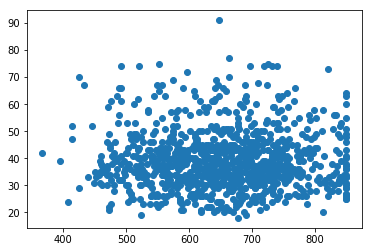

In [22]:
plt.scatter(df_x['CreditScore'], df_x['Age'])

In [17]:
model = smdis.Logit(df_y, df_x).fit()

Optimization terminated successfully.
         Current function value: 0.495422
         Iterations 6


In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Exited   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      988
Method:                           MLE   Df Model:                           11
Date:                Tue, 09 Jul 2019   Pseudo R-squ.:                  0.1355
Time:                        00:33:03   Log-Likelihood:                -495.42
converged:                       True   LL-Null:                       -573.06
Covariance Type:            nonrobust   LLR p-value:                 1.246e-27
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.4089      0.691     -4.930      0.000      -4.764      -2.054
Germany             0.3413      0.200      1.704      0.088      -0.051       0.734
Spain              -0.3357      0.210     -1.596      0.110      -0.748       0.077
Male               -0.5086      0.158     -3.221      0.001      -0.818      -0.199
CreditScore         0.0007      0.001      0.926      0.355      -0.001       0.002
Age                 0.0702      0.008      9.321      0.000       0.055       0.085
Tenure             -0.0255      0.027     -0.945      0.345      -0.078       0.027
Balance          2.141e-06   1.49e-06      1.434      0.151   -7.85e-07    5.07e-06
NumOfProducts      -0.1863      0.138     -1.353      0.176      -0.456       0.084
HasCrCard          -0.1405      0.168     -0.838      0.402      -0.469       0.188
IsActiveMember     -0.8545      0.163     -5.230      0.000      -1.175      -0.534
EstimatedSalary  7.777e-08   1.37e-06      0.057      0.955   -2.61e-06    2.76e-06
===================================================================================
"""

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?

In the above code, I took a dataset and from it, I made a graph to show the relationship between age and credit score in both Germany and Spain, I also created a model to help predict future data based on patterns in the current dataset. The most challenging part of this assignment for me was learning about a Python library I haven't come across thus far. This also tied into what was the most interesting thing I learned completing this assignment. With more time I would explore much more Python libraries because the more tools I can have at my disposal the more possibilities there will be with my code.



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.